In [1]:
import time
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import networkx as nx
# import xarray as xr
import seaborn as sns 
# from scipy.special import expit, logit
import scipy as sp
from itertools import combinations
from scipy.spatial.distance import cdist

import os


import jax
import jax.numpy as jnp
from jax import random, jit, vmap
from jax.scipy.special import expit, logsumexp
from functools import partial
import numpyro.distributions as dist 
import numpyro
from numpyro.contrib.funsor import config_enumerate
from numpyro.util import set_host_device_count
from numpyro.contrib.control_flow import scan
from numpyro.ops.indexing import Vindex
from tqdm import tqdm
from joblib import Parallel, delayed

from numpyro import handlers
from numpyro.infer import MCMC, HMC, NUTS, DiscreteHMCGibbs, MixedHMC, Predictive
import pyro
# import pymc_experimental as pmx

import multiprocessing
import socket
from hsgp.approximation import hsgp_squared_exponential


print(f"Running on PyMC v{pm.__version__}")
# print(f"Running on PyMC-experimental v{pmx.__version__}")
print(f"Running on NumPyro v{numpyro.__version__}")
print(f"Running on Pyro v{pyro.__version__}")
print(f"Running on JAX v{jax.__version__}")


WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Running on PyMC v5.15.1
Running on NumPyro v0.14.0
Running on Pyro v1.9.0+f02dfb9
Running on JAX v0.4.25


In [2]:
# Set CPU for JAX
os.environ["XLA_FLAGS"] = "--xla_force_host_platform_device_count=4"
print(jax.devices('cpu'))

[CpuDevice(id=0), CpuDevice(id=1), CpuDevice(id=2), CpuDevice(id=3)]


In [3]:
RANDOM_SEED = 892357143
rng = np.random.default_rng(RANDOM_SEED)

%config InlineBackend.figure_format = 'retina'
az.style.use("arviz-white")

(array([1.3632e+04, 1.1625e+04, 8.6880e+03, 5.4650e+03, 3.1560e+03,
        1.4630e+03, 5.9200e+02, 1.7700e+02, 4.7000e+01, 5.0000e+00]),
 array([1.68074152e-04, 1.52644491e+00, 3.05272175e+00, 4.57899859e+00,
        6.10527543e+00, 7.63155226e+00, 9.15782910e+00, 1.06841059e+01,
        1.22103828e+01, 1.37366596e+01, 1.52629365e+01]),
 <BarContainer object of 10 artists>)

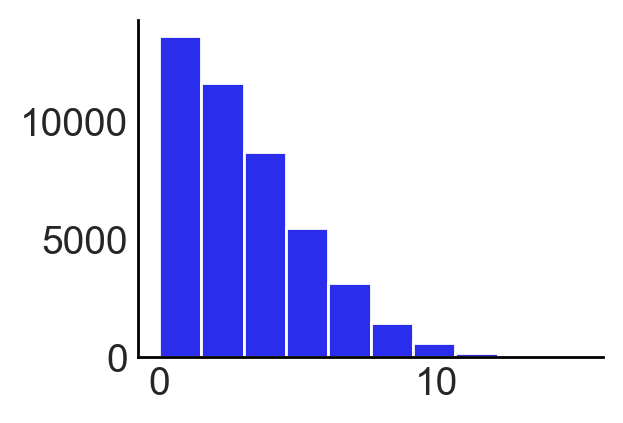

In [4]:
n=300
tril_dim = int(n*(n-1)/2)  
# x = rng.integers(low=0,high=1,size=n,endpoint=True)
x = rng.normal(loc=0,scale=3,size=n)
# x = rng.uniform(size=n,low=-3,high=3)
# x = rng.standard_t(size=n,df=5)
# x2 = rng.binomial(n=1,p=0.25,size=n)

# x_diff = []
# # x2_equal =[]
# for i in range(n):
#     for j in range(i+1,n):
#         x_diff.append(np.abs(x[i]-x[j]))
#         # x2_equal.append(x2[i]==x2[j])
# x_diff = np.array(x_diff)
# x2_equal = np.array(x2_equal)
# plt.hist(x_diff)
# Create probs
# beta = -3, -.5,2 
# beta = -2, -.5

idx_pairs = combinations(range(len(x)),2)
x_diff = np.array([abs(x[i] - x[j]) for i, j in idx_pairs])


plt.figure(figsize=(3,2))
plt.hist(x_diff)


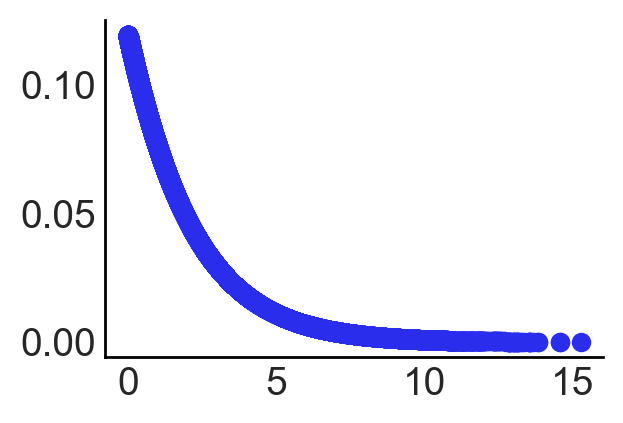

In [5]:
beta = -2, -0.5
# beta = -2, -1
# probs = expit(beta[0] + beta[1]*x_diff + rng.normal(-.5,1,tril_dim))
# probs = expit(beta[0] + beta[1]*x_diff + beta[2]*x2_equal)
# probs = expit(beta[0] + beta[1]*x_diff + beta[2]*x2_equal)
probs = expit(beta[0] + beta[1]*x_diff)

plt.figure(figsize=(3,2))
plt.scatter(x_diff,probs)

# Generate adj. matrix
mat = np.zeros((n,n))
# idx_lt = np.tril_indices(n=n,k=-1)
idx_ut = np.triu_indices(n=n,k=1)
# edges = rng.binomial(n=1,p=0.5,size=tril_dim)
edges = rng.binomial(n=1,p=probs,size=tril_dim)

mat[idx_ut] = edges
# mat[idx_lt] = edges
mat = mat + mat.T
triu_vals = mat[np.triu_indices(n,k=1)]





In [6]:
# def eigen_centrality(adj_mat):
#     sparse_mat = sp.sparse.csr_matrix(adj_mat)
#     _, eig_vec = sp.sparse.linalg.eigs(sparse_mat, k=1, which = 'LR')
#     largest_v = eig_vec.flatten().real
#     norm = np.sign(largest_v.sum()) * sp.linalg.norm(largest_v)
#     return largest_v / norm

@jit
def eigen_centrality(adj_mat):
    # Ensure the matrix is symmetric
    # adj_mat = (adj_mat + adj_mat.T) / 2
    
    # Compute the eigenvalues and eigenvectors
    eigenvalues, eigenvectors = jnp.linalg.eigh(adj_mat)
    
    # Find the index of the largest eigenvalue
    largest_eigenvalue_index = jnp.argmax(eigenvalues)
    
    # Get the corresponding eigenvector
    largest_eigenvector = eigenvectors[:, largest_eigenvalue_index]
    
    # Scale the eigenvector
    norm = jnp.sign(largest_eigenvector.sum()) * jnp.linalg.norm(largest_eigenvector)
    scaled_eigenvector = largest_eigenvector / norm
    
    return scaled_eigenvector

In [7]:
eigen_center = eigen_centrality(mat)
# eigen_center_jx = eigen_centrality_jax(mat)

# print(jnp.array_equal(jnp.round(eigen_center,5), jnp.round(eigen_center_jx,5)))

# plt.figure(figsize=(3,2))
# plt.scatter(eigen_center, eigen_center_jx)


sum eigen 15.751848


(array([19., 19., 26., 49., 59., 54., 35., 17., 17.,  5.]),
 array([0.00111739, 0.01233844, 0.0235595 , 0.03478055, 0.04600161,
        0.05722266, 0.06844372, 0.07966477, 0.09088582, 0.10210688,
        0.11332793]),
 <BarContainer object of 10 artists>)

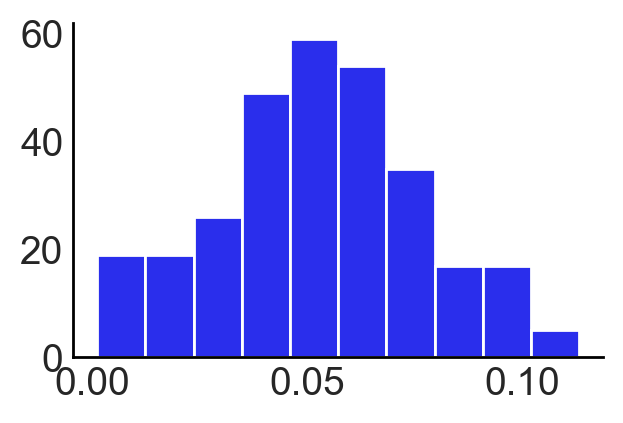

In [8]:
print("sum eigen", np.sum(eigen_center))
plt.figure(figsize=(3,2))
plt.hist(eigen_center)

In [9]:
# mat_net = nx.from_numpy_array(mat)
# 
# degrees = np.array([degree for _, degree in mat_net.degree()])
# deg_center = np.array(list(nx.degree_centrality(mat_net).values()))
# eigen_center = np.array(list(nx.eigenvector_centrality_numpy(mat_net).values()))
# closeness = np.array(list(nx.closeness_centrality(mat_net).values()))
# betweeness = np.array(list(nx.betweenness_centrality(mat_net).values()))
# # flow_betweeness = np.array(list(nx.current_flow_betweenness_centrality(mat_net).values()))
# # flow_betweeness = np.array(list(nx.approximate_current_flow_betweenness_centrality(mat_net,epsilon=0.1).values()))
# triangles = np.array(list(nx.triangles(mat_net).values()))
# clustering = np.array(list(nx.clustering(mat_net).values()))


In [10]:
# plt.figure(figsize=(5,3))
# np.array(list(eigen_center)).shape
# plt.hist(degrees)
# plt.hist(triangles)
# plt.hist(clustering)
# plt.hist(closeness)
# plt.hist(flow_betweeness)
# plt.hist(betweeness)
# plt.hist(closeness*triangles)
# plt.scatter(deg_center,degrees)
# plt.scatter(degrees,closeness)
# plt.scatter(betweeness,closeness)
# plt.scatter(betweeness,flow_betweeness)
# plt.scatter(triangles,flow_betweeness)
# plt.scatter(app_flow_betweeness,flow_betweeness)
# plt.scatter(triangles,closeness)
# plt.scatter(triangles,betweeness)
# plt.scatter(betweeness,degrees)
# plt.scatter(betweeness,triangles)
# plt.scatter(triangles,degrees)
# plt.scatter(triangles,betweeness)
# plt.scatter(triangles,eigen_center)
# plt.scatter(manual_eig_center,eigen_center)

In [11]:
# print(min(betweeness),max(betweeness))
# print(min(eigen_center),max(eigen_center))
# print(min(triangles),max(triangles))


In [12]:
@jit
def zeigen_value(Z, eig_cen, A_mat):
    if Z.ndim == 1:  # Case when Z has shape (N,)
        return jnp.dot(A_mat, Z * eig_cen)
    elif Z.ndim == 2:  # Case when Z has shape (M, N)
        return jnp.dot(Z * eig_cen, A_mat.T)  # Transpose A_mat for correct dimensions
    # return jnp.dot(Z*eig_cen, A_mat.T)
    # return jnp.dot(A_mat, Z*eig_cen)
    # return jnp.dot(A_mat, Z*eig_cen)
    # return jnp.dot(A_mat, jnp.multiply(Z, eig_cen))

           zeigen       expos    exposinv           Z
count  300.000000  300.000000  300.000000  300.000000
mean     0.242005    0.307272   57.056667    0.303333
std      0.156462    0.153598   34.790728    0.460466
min      0.000000    0.000000    0.000000    0.000000
25%      0.122793    0.214286   31.000000    0.000000
50%      0.224863    0.297059   55.500000    0.000000
75%      0.353849    0.391667   81.000000    1.000000
max      0.703032    1.000000  153.000000    1.000000
[[1.         0.52029221]
 [0.52029221 1.        ]]


(array([47., 43., 50., 51., 32., 36., 22.,  7.,  8.,  4.]),
 array([0.        , 0.07030321, 0.14060642, 0.21090962, 0.28121284,
        0.35151604, 0.42181924, 0.49212244, 0.56242567, 0.63272887,
        0.70303208]),
 <BarContainer object of 10 artists>)

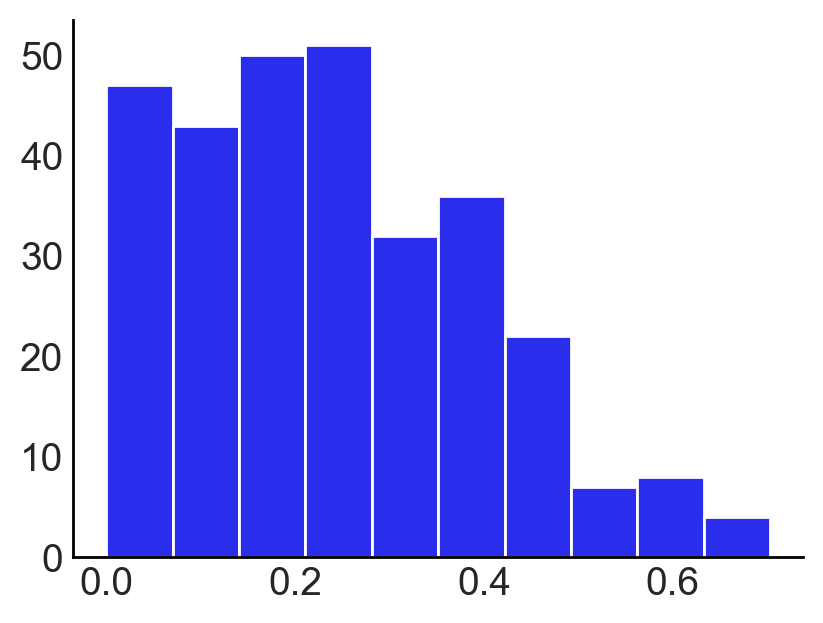

In [13]:
# Create outcome data

Z = rng.binomial(n=1,p=0.3,size=n)
degrees = np.sum(mat,1)
exposures = np.dot(mat,Z) / degrees
exposures_inv_deg = np.dot(mat,Z*degrees)
# print(pd.DataFrame(exposures).describe())
# x_neighbors = np.dot(mat,x) / degrees
# print(pd.DataFrame(x_neighbors).describe())
# print(pd.DataFrame(x).describe())

# Zeigen = np.dot(mat, Z*eigen_center)
Zeigen = zeigen_value(Z, eigen_center, mat)

print(pd.DataFrame({"zeigen": Zeigen,"expos" : exposures, "exposinv":exposures_inv_deg,
                    "Z" : Z}).describe())
print(np.corrcoef(Zeigen,exposures))
# expos_binary = exposures > 0.5
# print(np.mean(expos_binary))

plt.figure(figsize=(4,3))
plt.hist(Zeigen)
# plt.scatter(exposures, Zeigen)
# plt.scatter(exposures_inv_deg, exposures)

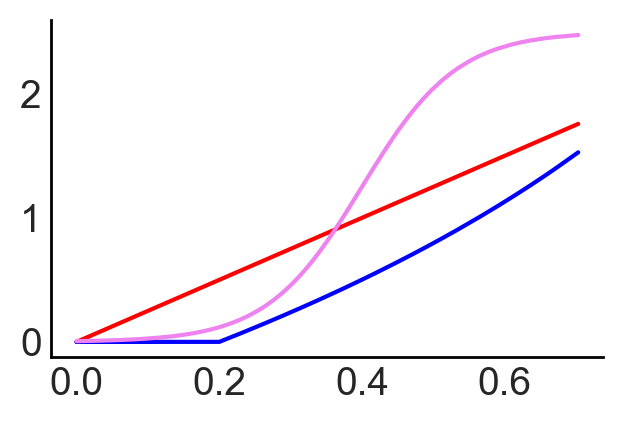

In [14]:
s = np.sort(Zeigen)
f1 = 2.5*s
# f2 = 0*(x < 0.25) + 0.2*np.exp(2*x)*(x>=0.25)
f2 = 0*(s < 0.2) -2.5*(np.log(1-(s-0.2)/1.1))*(s>=0.2)
f3 = 2.5 / (1+np.exp(-15*(s-0.4)))

plt.figure(figsize=(3,2))
plt.plot(s,f1, c="red")
plt.plot(s,f2, c="blue")
plt.plot(s,f3, c="violet")
# plt.axvline(0.25, c="black")


(array([ 4., 16., 29., 60., 66., 44., 28., 27., 18.,  8.]),
 array([-3.62493843, -2.78682746, -1.94871649, -1.11060552, -0.27249455,
         0.56561642,  1.40372739,  2.24183836,  3.07994933,  3.9180603 ,
         4.75617127]),
 <BarContainer object of 10 artists>)

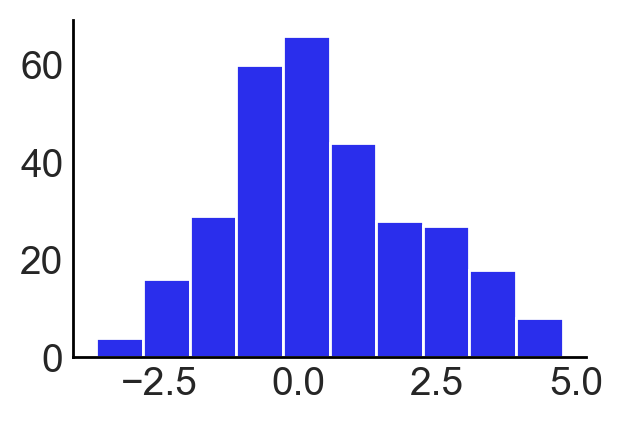

In [15]:
# alpha = -.5, 2, 1, -1
# alpha = -1, 3, 1, 0.5, -0.25
# alpha = -.5, 2, .5, 0.25, -0.25
# alpha = -.5, 2, 0.5, -0.25, -0.25
# alpha = -2, 3, 1, -.5
# alpha = -1, 3, 2, -.25, 5, 5 
# alpha = -1, 3, -.25, 2.5, 2 

alpha = -1, 3, -.25, 2.5 

def gen_y(df_lin, Zeigen, alpha, lin=True):
    Nn = Zeigen.shape[0]
    epsi = rng.normal(loc=0,scale=.5,size=Nn)
    if lin:
        mean_y = np.dot(np.column_stack((df_lin,Zeigen)), alpha)
    else:
        mean_lin = np.dot(df_lin, alpha[0:3]) 
        # mean_nonlin = 0*(Zeigen < 0.2) + (alpha[3]*3)*(Zeigen-0.2)*(Zeigen>=0.2)        
        # mean_nonlin = 0*(Zeigen < 0.2)  - alpha[3]*(np.log(1-(Zeigen-0.2)/1.1))*(Zeigen>=0.2)        
        mean_nonlin = alpha[3] / (1+np.exp(-15*(Zeigen-0.4)))        
        mean_y = mean_lin + mean_nonlin

    Y = mean_y + epsi
    return Y, epsi

# df_array = np.transpose(np.array([[1]*n,Z,exposures,x,eigen_center,betweeness]))
# df_array = np.transpose(np.array([[1]*n, Z, x, Zeigen,exposures]))
df_array = np.transpose(np.array([[1]*n, Z, x, Zeigen]))
df_lin = np.transpose(np.array([[1]*n, Z, x]))
# mean_y = np.dot(df_array,alpha)
# # Y = alpha[0] + alpha[1]*Z + alpha[2]*exposures + alpha[3]*x + alpha[4] + rng.normal(loc=0,scale=1,size=n)
# epsilon = rng.normal(loc=0,scale=1,size=n)
# Y = mean_y + epsilon

# Y, epsilon = gen_y(df_lin, Zeigen, alpha, lin=True)
Y, epsilon = gen_y(df_lin, Zeigen, alpha, lin=False)
# Y, epsilon = gen_y(df_lin, Zeigen, alpha, lin=True)

plt.figure(figsize=(3,2))
plt.hist(Y)


(array([10., 16., 17., 31., 34., 78., 54., 32., 15., 13.]),
 array([ 1. ,  3.2,  5.4,  7.6,  9.8, 12. , 14.2, 16.4, 18.6, 20.8, 23. ]),
 <BarContainer object of 10 artists>)

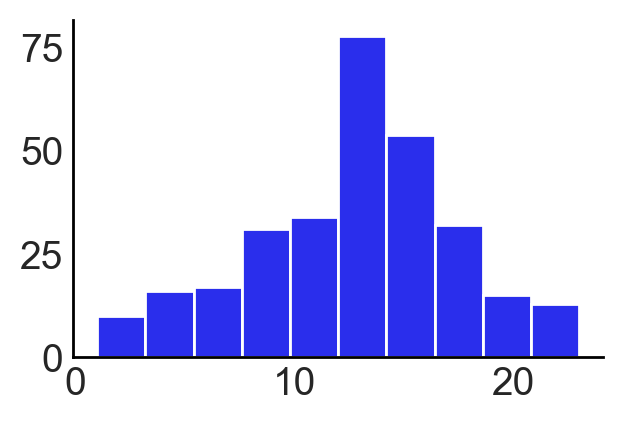

In [16]:
plt.figure(figsize=(3,2))
plt.hist(degrees)

[[1.         0.37113528]
 [0.37113528 1.        ]]


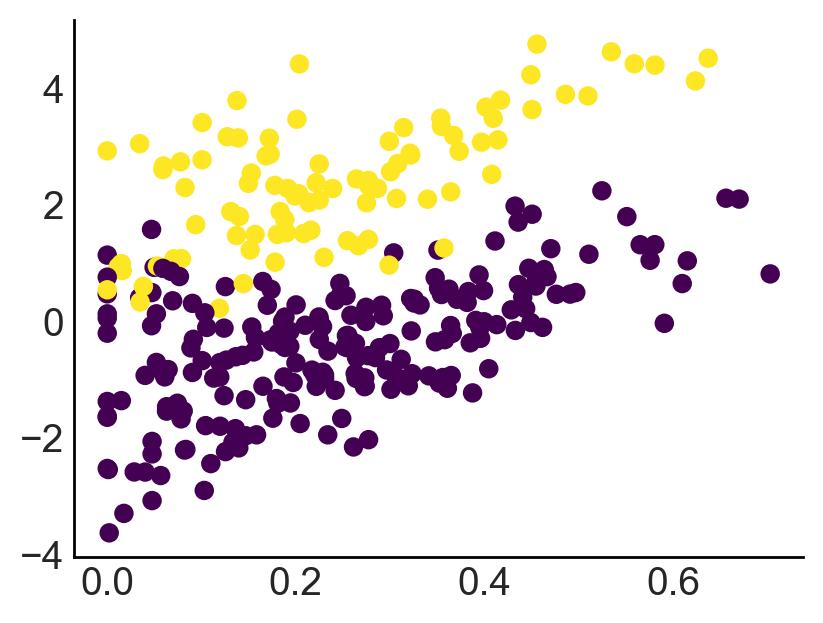

In [17]:
plt.figure(figsize=(4,3))
# plt.scatter(exposures,betweeness)
# plt.scatter(exposures,eigen_center)

# print(np.corrcoef(eigen_center,Zeigen))
print(np.corrcoef(Zeigen,Y))
# plt.scatter(eigen_center,Zeigen)
plt.scatter(Zeigen,Y,c=Z)
# plt.scatter(exposures,Zeigen)
# plt.scatter(exposures/degrees,Zeigen)
# plt.scatter(betweeness,eigen_center)
# plt.hist(Zeigen)
# plt.hist(exposures/degrees)

In [18]:
# DG = nx.from_numpy_array(mat)
# nx.set_node_attributes(DG, Z, "Treatments") 
# nx.draw(DG, with_labels=True,  node_color = Z)
# plt.legend()
# plt.show()

In [19]:
# Create noisy measurement of `mat`
# gamma1 = 0.25  # Remove existing edge with prob `alph`
gamma1 = 0.25  # Remove existing edge with prob `alph`
# gamma0 = gamma1/5 # add non-existing edge with prob `bet` 
gamma0 = 0.05 # add non-existing edge with prob `bet` 

obs_mat = np.zeros((n,n)) # create nXn matrix of zeros
# obs_mat[np.tril_indices(n=n,k=-1)] = tril_vals # init as true network
obs_mat[np.triu_indices(n=n,k=1)] = triu_vals # init as true network
for i in range(0,n): # add noise
    for j in range(i+1,n):
        if mat[i,j] == 1:
            obs_mat[i,j] = rng.binomial(n=1,p=1-gamma1,size=1)[0] # retain existing edge w.p. `1-gamma1`
        else:
            obs_mat[i,j] = rng.binomial(n=1,p=gamma0,size=1)[0] # add non-existing edge w.p. `gamma0` 
            
obs_mat = obs_mat + obs_mat.T
triu_obs = obs_mat[np.triu_indices(n=n,k=1)]
# tril_obs = obs_mat[np.tril_indices(n=n,k=-1)]


(array([ 8., 12., 40., 35., 36., 70., 50., 32., 12.,  5.]),
 array([12. , 14.4, 16.8, 19.2, 21.6, 24. , 26.4, 28.8, 31.2, 33.6, 36. ]),
 <BarContainer object of 10 artists>)

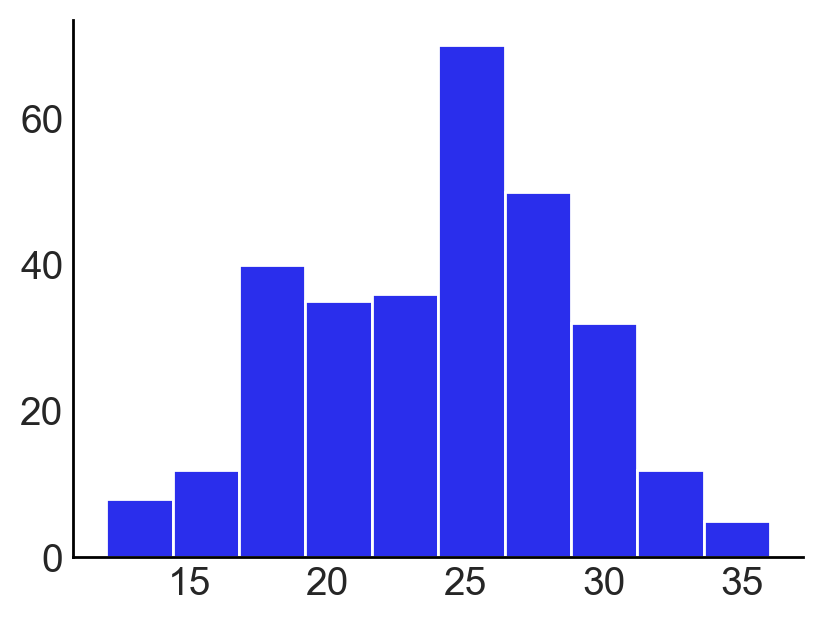

In [20]:
# Plot noisy observed network 
# DG_noise = nx.from_numpy_array(obs_mat)
# nx.draw(DG_noise, with_labels=True,  node_color = Z)
# plt.show()
plt.figure(figsize=(4,3))
plt.hist(np.sum(obs_mat,1))

In [21]:
trils_pd = pd.DataFrame({'true' : triu_vals, 'obs' : triu_obs})
pd.crosstab(index=trils_pd['true'], columns=trils_pd['obs'])


obs,0.0,1.0
true,,
0.0,40784,2157
1.0,467,1442


                0
count  300.000000
mean     0.305400
std      0.098219
min      0.047619
25%      0.238095
50%      0.309019
75%      0.368421
max      0.600000
Corr obs~true exposures:  0.5082920580832014
Corr obs~true Zeigen:  0.6082595155230667


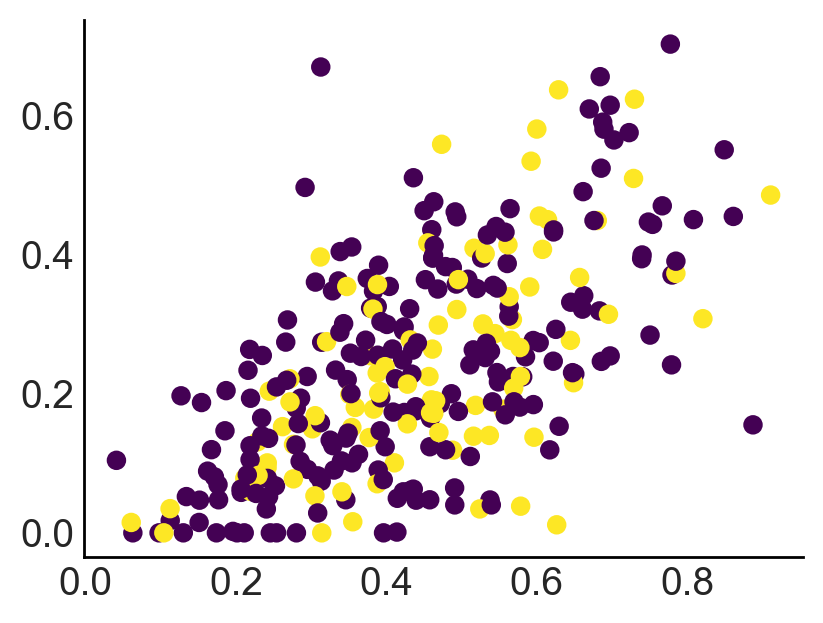

In [22]:

# obs_exposures = np.dot(obs_mat,Z)/np.sum(obs_mat,1) > 0.5
# # obs_exposures = np.dot(obs_mat,Z)
# obs_exposures = np.dot(obs_mat,Z)


# obs_net = nx.from_numpy_array(obs_mat)
# obs_deg = np.array([degree for _, degree in obs_net.degree()])
# obs_betweeness = np.array(list(nx.betweenness_centrality(obs_net).values()))
# obs_triangles = np.array(list(nx.triangles(obs_net).values()))
# obs_eigen_center = np.array(list(nx.eigenvector_centrality_numpy(obs_net).values()))
obs_degrees = np.sum(obs_mat,1)
obs_eigen_cent = eigen_centrality(obs_mat)
obs_exposures = np.dot(obs_mat,Z) / obs_degrees
# obs_Zeigen = np.dot(obs_mat, Z*obs_eigen_cent)
obs_Zeigen = zeigen_value(Z, obs_eigen_cent, obs_mat)

# obs_df = np.transpose(np.array([[1]*n, Z, obs_exposures,x, obs_eigen_center, obs_betweeness]))
# obs_df = np.transpose(np.array([[1]*n, Z, x, obs_Zeigen, obs_exposures]))
obs_df = np.transpose(np.array([[1]*n, Z, x, obs_Zeigen]))

print(pd.DataFrame(obs_exposures).describe())

print("Corr obs~true exposures: ", np.corrcoef(exposures, obs_exposures)[1,0])
print("Corr obs~true Zeigen: ", np.corrcoef(Zeigen, obs_Zeigen)[1,0])

# obs_exposures = np.dot(obs_mat,Z)/np.sum(obs_mat,1)
# expos_pd = pd.DataFrame({'true' : exposures, 'obs' : obs_exposures})
# pd.crosstab(index=expos_pd['true'], columns=expos_pd['obs'])
plt.figure(figsize=(4,3))
# plt.scatter(obs_exposures,exposures, c=Z)
plt.scatter(obs_Zeigen,Zeigen, c=Z)

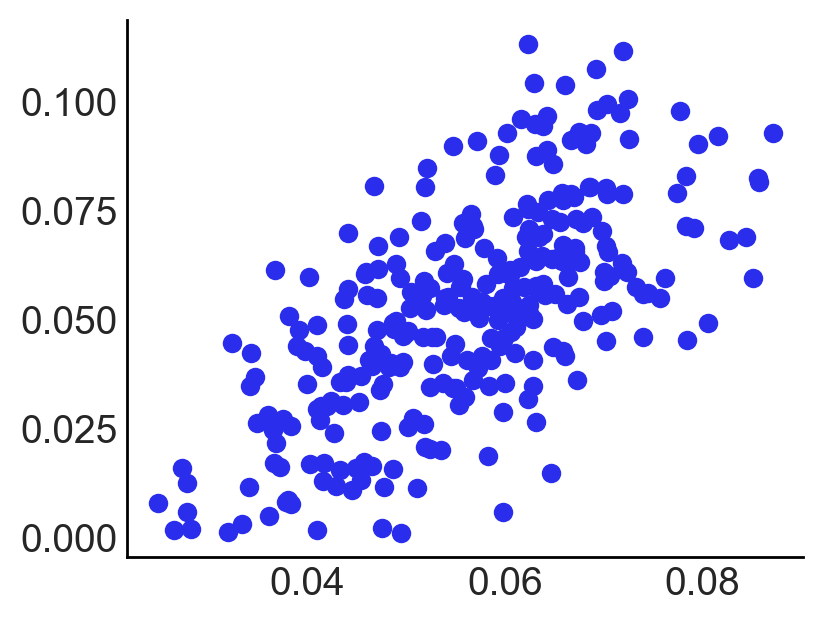

In [23]:
plt.figure(figsize=(4,3))
# plt.scatter(obs_betweeness, betweeness)
plt.scatter(obs_eigen_cent, eigen_center)

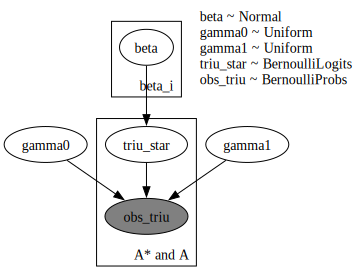

In [24]:
# NumPyro model
# def triu_to_mat(triu, n):
#     adj_mat = jnp.zeros((n,n))
#     idx_utri = np.triu_indices(n=n,k=1)
#     adj_mat = adj_mat.at[idx_utri].set(triu) 
#     return adj_mat + adj_mat.T

NN = n

@jit
def Triu_to_mat(triu_v):
    adj_mat = jnp.zeros((NN,NN))
    # idx_utri = np.triu_indices(n=NN,k=1)
    adj_mat = adj_mat.at[np.triu_indices(n=NN,k=1)].set(triu_v) 
    return adj_mat + adj_mat.T


@config_enumerate
def network_model(X, TriU):
    # Network model
    # beta_0 = numpyro.sample("beta0",dist.Normal(0,10))
    # beta_1 = numpyro.sample("beta1",dist.Normal(0,10))
    with numpyro.plate("beta_i",2):
        beta = numpyro.sample("beta", dist.Normal(0,10))
    mu_net = beta[0] + beta[1]*X 
    # triu_n = int(n*(n-1)/2)
    
    gamma0 = numpyro.sample("gamma0", dist.Uniform(low=0,high=0.5))
    gamma1 = numpyro.sample("gamma1", dist.Uniform(low=0,high=0.5))
    # gamma0 = numpyro.sample("gamma0", dist.Beta(2,5))
    # gamma1 = numpyro.sample("gamma1", dist.Beta(2,5))
    
    with numpyro.plate("A* and A", TriU.shape[0]):
        triu_star = numpyro.sample("triu_star",dist.Bernoulli(logits=mu_net),
                                   infer={"enumerate": "parallel"})
        # prob_misspec = jnp.where(triu_star==1, 1-gamma1, gamma0)
        prob_misspec = triu_star*(1-gamma1) + (1-triu_star)*gamma0
        numpyro.sample("obs_triu", dist.Bernoulli(probs = prob_misspec), obs = TriU)
        
    # def triu_fn(carry, inp):
    #     # print("Starting tril_fn carry no.", carry)
    #     # mu_n = inp
    #     mu_n, triu_val = inp
    #     # logp of A* 
    #     # with numpyro.plate("Edges A*", triu_n):
    #     triu_star = numpyro.sample("triu_star",dist.Bernoulli(logits=mu_n),
    #                                infer={"enumerate": "parallel"})
    #     # print("Triu_Star shape (within) is", triu_star.shape)
    #     # # logp of A|A*
    #     # # with numpyro.plate("A|A*", 1):
    #     prob_misspec = jnp.where(triu_star==1, 1-gamma1, gamma0)
    #     # print("prob_misspec shape is: ", prob_misspec.shape)
    #     # obs_triu_vals = numpyro.sample("obs_triu", dist.Bernoulli(probs = prob_misspec), obs = TriU)
    #     return carry+1, triu_star  
    # 
    # sc_input = jnp.array((mu_net, TriU)).T
    # _, triu_var = scan(triu_fn, jnp.array(0), sc_input)
    # print("triu_var shape is: ", triu_var.shape)
    # scan(triu_fn, jnp.array(0), sc_input)    
    # 


# def outcome_model(Y,Z,X,A,n):

def outcome_model(X, Y=None):
    with numpyro.plate("Lin coef.",X.shape[1]):
        alpha = numpyro.sample("alpha",dist.Normal(0,10))
    sig = numpyro.sample("sig",dist.HalfNormal(scale=2))
    # sig = numpyro.sample("sig",dist.Exponential(0.5))
    
    # expos = jnp.dot(A,Z)
    # expos = (jnp.dot(A,Z) / jnp.sum(A,1)) > 0.5
    # sum_expos = jnp.dot(A,Z)
    # deg = jnp.sum(A,1)
    # expos = jnp.where(jnp.equal(deg,0), 0, sum_expos/deg)
    # mu_y = alpha[0] + alpha[1]*Z + alpha[2]*expos + alpha[3]*X 
    mu_y = jnp.dot(X, alpha)
    # mu_y = alpha[0] + alpha[1]*Z + alpha[2]*expos + alpha[3]*deg  + alpha[4]*X
    # mu_y = alpha[0] + alpha[1]*Z + alpha[2]*expos + alpha[3]*expos*Z + alpha[4]*deg
    # mu_y = alpha[0] + alpha[1]*Z + alpha[2]*expos + alpha[3]*expos*Z + alpha[4]*deg
    with numpyro.plate("obs",X.shape[0]):
        numpyro.sample("Y", dist.Normal(loc=mu_y,scale=sig), obs=Y)
        
        
def HSGP_model(Xlin, Xgp, ell, m, Y=None, non_centered=True):
    # --- Priors ---
    magn = numpyro.sample("magn", dist.HalfNormal(2))
    length = numpyro.sample("length", dist.HalfNormal(5))
    sig = numpyro.sample("sig", dist.HalfNormal(2))
    # --- Parametrization ---
    f = hsgp_squared_exponential(
        x=Xgp, alpha=magn, length=length, ell=ell, m=m, non_centered=non_centered
    )
    with numpyro.plate("Lin coef.",Xlin.shape[1]):
        alpha = numpyro.sample("alpha",dist.Normal(0,10))
    # mu = numpyro.deterministic("mu", jnp.dot(Xlin, alpha) + f)
    mu = jnp.dot(Xlin, alpha) + f
    # mu = beta0 + beta1*x_lin + f
    # --- Likelihood ---
    with numpyro.plate("obs", Xlin.shape[0]):
        # numpyro.sample("likelihood", dist.Normal(loc=mu, scale=noise), obs=y)
        # numpyro.sample("Y", dist.Normal(loc=f, scale=noise), obs=y)
        # numpyro.sample("Y", dist.Normal(loc=mu, scale=sig), obs=Y, sample_shape=(Xgp.shape[0],))
        numpyro.sample("Y", dist.Normal(loc=mu, scale=sig), obs=Y)
        

# numpyro.render_model(model, model_args=(Y,Z,x_diff,triu_obs,n), render_distributions=True)
numpyro.render_model(network_model, model_args=(x_diff,triu_obs), render_distributions=True)
# numpyro.render_model(model, model_args=(Y,Z,x_diff,tril_vals))

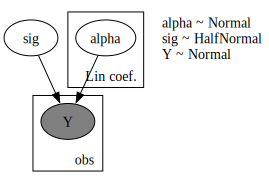

In [25]:
# numpyro.render_model(outcome_model, model_args=(Y,Z,x,mat,n), render_distributions=True)

df_array = jnp.array(df_array)
Y = jnp.array(Y)

numpyro.render_model(outcome_model, model_args=(df_array,Y), render_distributions=True)

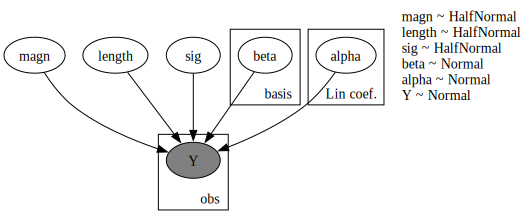

In [26]:
c = 3.5

Xgp = jnp.array(df_array[:,3:])
Xlin = jnp.array(df_array[:,0:3])
# ell = 3.5*np.max(np.abs(df_array[:,3:]))
ell = jnp.array(c*np.max(np.abs(Xgp))).reshape(1,1)
m = 20
# m = 10
# m = 50

numpyro.render_model(HSGP_model, model_args=(Xgp, Xlin, ell, m, Y), render_distributions=True)

In [27]:
# A* and A|A* models

rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)

start = time.time()
# kernel = DiscreteHMCGibbs(NUTS(model))
# kernel = MixedHMC(HMC(model, trajectory_length=1.2))  
# kernel = NUTS(model, dense_mass=True)
kernel_network = NUTS(network_model)
mcmc_network = MCMC(kernel_network, num_warmup=2000, num_samples=4000,num_chains=4)
# mcmc.run(rng_key_,Y=Y,Z=Z,expos=obs_exposures,X=x_diff,TriL=tril_obs,n=100)
# mcmc.run(rng_key_,Y=Y,Z=Z,X=x_diff,TriU=triu_obs,n=n)
mcmc_network.run(rng_key_,X=x_diff,TriU=triu_obs)
mcmc_network.print_summary()
samples_network = mcmc_network.get_samples()
print(time.time() - start)

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
   beta[0]     -1.90      0.26     -1.91     -2.31     -1.51   4484.94      1.00
   beta[1]     -0.58      0.07     -0.58     -0.69     -0.46   6202.34      1.00
    gamma0      0.05      0.00      0.05      0.05      0.06   6416.06      1.00
    gamma1      0.27      0.15      0.28      0.06      0.50   4580.08      1.00

Number of divergences: 0
368.3452785015106


In [28]:
@jit
def Astar_pred(key, post_samples, Xd, triu):
    # if mean_post:
    pred_func = Predictive(model=network_model, posterior_samples=post_samples, infer_discrete=True,num_samples=1)
    # else:
    #     pred_func = Predictive(model=network_model, posterior_samples=post_samples, infer_discrete=True)
    return pred_func(key, X=Xd, TriU=triu)
        

In [ ]:
# Outcome model with A* (true network)

# start = time.time()
kernel_outcome = NUTS(outcome_model)
mcmc_network_true = MCMC(kernel_outcome, num_warmup=2000, num_samples=4000,num_chains=4, jit_model_args=True, chain_method="vectorized")
                         # chain_method="vectorized")
# mcmc_network_true = MCMC(kernel_outcome, num_warmup=2000, num_samples=4000,num_chains=4)
# mcmc_network_true = MCMC(kernel_outcome, num_warmup=100, num_samples=10,num_chains=1)
# mcmc_network_true.run(rng_key_,Y=Y,Z=Z,A=obs_mat,n=n)
# mcmc_network_true.run(rng_key_,Y=Y,Z=Z,X=x,A=mat,n=n)
mcmc_network_true.run(rng_key_,X=df_array,Y=Y)
mcmc_network_true.print_summary()
samples_net_true = mcmc_network_true.get_samples()
true_net_lin_predictive = Predictive(outcome_model, samples_net_true)

# print(time.time() - start)

In [ ]:
start = time.time()
mcmc_network_true.run(rng_key,X=df_array,Y=Y)
true_samps = mcmc_network_true.get_samples()
# mcmc_network_true.print_summary()
print(time.time()-start)

In [29]:
@jit
def linear_model_samples(key, Y, df):
    kernel_outcome = NUTS(outcome_model)
    # lin_mcmc = MCMC(kernel_outcome, num_warmup=2000, num_samples=4000,num_chains=4, progress_bar=False)
    lin_mcmc = MCMC(kernel_outcome, num_warmup=2000, num_samples=4000,num_chains=4, progress_bar=False, chain_method="vectorized")
    # mcmc.run(key, Y=Y, Z=Z, X=X, A=A, n=NN)
    lin_mcmc.run(key, X=df, Y=Y)
    return lin_mcmc.get_samples()

@jit
def outcome_jit_pred(post_samples, df_arr, key=rng_key):
    pred_func = Predictive(outcome_model, post_samples)
    return pred_func(key, df_arr)



In [30]:
start = time.time()
samples_net_true = linear_model_samples(rng_key,Y=Y, df=df_array)
print(time.time()-start)

12.35438871383667


In [ ]:
# Outcome model with A (observed network)

# start = time.time()
kernel_outcome = NUTS(outcome_model)
mcmc_network_obs = MCMC(kernel_outcome, num_warmup=2000, num_samples=4000,num_chains=4)
# mcmc_network_obs.run(rng_key_,Y=Y,Z=Z,X=x,A=obs_mat,n=n)
mcmc_network_obs.run(rng_key_, X=obs_df, Y=Y)
# mcmc_network_obs.run(rng_key_,Y=Y,Z=Z,A=mat,n=n)
mcmc_network_obs.print_summary()
samples_net_obs = mcmc_network_obs.get_samples()
obs_net_lin_predictive = Predictive(outcome_model, samples_net_obs)

# print(time.time() - start)

In [31]:
samples_net_obs = linear_model_samples(rng_key_,Y=Y, df=jnp.array(obs_df))


In [ ]:
plt.figure(figsize=(3,2))
plt.hist(samples_net_obs["alpha"][:,4])
plt.axvline(x=alpha[3], color="red")

In [ ]:
print([f"beta_{i} = {bet}" for i,bet in enumerate(beta)], "gamma0:", gamma0, "gamma1:", gamma1)
print([f"alpha_{i} = {al}" for i,al in enumerate(alpha)],"sig:", 1)

In [ ]:
# start = time.time()
kernel_gp_outcome = NUTS(HSGP_model)
mcmc_GP_network_true = MCMC(kernel_gp_outcome, num_warmup=2000, num_samples=4000,num_chains=4)
# mcmc_network_true = MCMC(kernel_outcome, num_warmup=100, num_samples=10,num_chains=1)
# mcmc_network_true.run(rng_key_,Y=Y,Z=Z,A=obs_mat,n=n)
# mcmc_network_true.run(rng_key_,Y=Y,Z=Z,X=x,A=mat,n=n)
mcmc_GP_network_true.run(rng_key_,Xgp=Xgp, Xlin=Xlin, ell=ell ,m=m, Y=Y)
# mcmc_GP_network_true.run(rng_key_,Xgp=Zeigen, Xlin=Xlin, Y=Y, ell=ell ,m=m)
mcmc_GP_network_true.print_summary()
samples_GP_net_true = mcmc_GP_network_true.get_samples()
# print(time.time() - start)
HSGP_true_predictive = Predictive(HSGP_model, samples_GP_net_true)


In [32]:
M = m
num_warmup=2000
# num_warmup=250
# num_samples=25
num_samples=4000
num_chains=4

@jit    
def HSGP_model_samples(key, Y, Xgp, Xlin, ell):
    kernel_hsgp = NUTS(HSGP_model)
    hsgp_mcmc = MCMC(kernel_hsgp, num_warmup=num_warmup, num_samples=num_samples,num_chains=num_chains, progress_bar=False, chain_method="vectorized")
    # mcmc.run(key, Y=Y, Z=Z, X=X, A=A, n=NN)
    hsgp_mcmc.run(key, Xgp=Xgp, Xlin=Xlin, ell=ell ,m=M, Y=Y)
    # hsgp_mcmc.print_summary()
    # samples = hsgp_mcmc.get_samples()
    # hsgp_pred = Predictive(HSGP_model, hsgp_mcmc.get_samples())
    # return hsgp_pred
    return hsgp_mcmc.get_samples()

@jit
def HSGP_jit_pred(post_samples, Xgp, Xlin, ell):
    pred_func = Predictive(HSGP_model, post_samples)
    return pred_func(rng_key, Xgp=Xgp, Xlin = Xlin, ell=ell, m=M)




In [33]:

samples_GP_net_true = HSGP_model_samples(rng_key_,Y=Y, Xgp=Xgp, Xlin=Xlin, ell=ell)
# HSGP_true_predictive = Predictive(HSGP_model, samples_GP_net_true)


In [34]:
# HSGP with noisy data
Xlin_obs = jnp.array(obs_df[:,0:3])
Xgp_obs = jnp.array(obs_df[:,3:])
ell_obs = jnp.array(c*jnp.max(jnp.abs(Xgp_obs))).reshape(1,1)



In [ ]:

kernel_gp_outcome = NUTS(HSGP_model)
mcmc_GP_network_obs = MCMC(kernel_gp_outcome, num_warmup=2000, num_samples=4000,num_chains=4)
mcmc_GP_network_obs.run(rng_key_,Xgp=Xgp_obs, Xlin=Xlin_obs, ell=ell ,m=m, Y=Y)
# mcmc_GP_network_true.run(rng_key_,Xgp=Zeigen, Xlin=Xlin, Y=Y, ell=ell ,m=m)
mcmc_GP_network_obs.print_summary()
mcmc_GP_network_obs = mcmc_GP_network_obs.get_samples()
# print(time.time() - start)
HSGP_obs_predictive = Predictive(HSGP_model, mcmc_GP_network_obs)



In [35]:

samples_GP_net_obs = HSGP_model_samples(rng_key_,Y=Y, Xgp=Xgp_obs, Xlin=Xlin_obs, ell=ell_obs)
# mcmc_GP_network_obs = HSGP_model_samples(rng_key_,Y=Y, Xgp=jnp.array(Xgp_obs), Xlin=jnp.array(Xlin_obs), ell=jnp.array(ell_obs).reshape(1,1))
# HSGP_obs_predictive = Predictive(HSGP_model, samples_GP_net_obs)



In [36]:
# h_x = ((x > 1.5) | (x < -1.5)).astype(int)
# h_x2 = ((x > 2) | (x < 2)).astype(int)

def Dynamic_intervention(x, threshold = 1.5):
    return np.where((x > threshold) | (x < -threshold), 1, 0)
    # return ((x > threshold) | (x < threshold)).astype(int)

def Stochastic_interention(alph, n_approx = 1e4):
    return rng.binomial(n=1, p=alph, size=(n_approx,n))
# 
# # h_x = np.array([1]*n)
# h_x = rng.binomial(n=1,p=0.6,size=n)
# h_x2 = rng.binomial(n=1,p=0.2,size=n)

h_1 = Dynamic_intervention(x)
Z_stoch = Stochastic_interention(alph=0.4, n_approx=10)

h_zeigen = zeigen_value(h_1, eigen_center, mat)
h_zeigen_obs = zeigen_value(h_1, obs_eigen_cent, obs_mat)

Stoch_zeigen = zeigen_value(Z_stoch, eigen_center, mat)

print(h_1.shape)
print(h_zeigen.shape)
print(Z_stoch.shape)
print(Z_stoch[0,].shape)
print(Z_stoch[0].shape)
print(Stoch_zeigen.shape)

(300,)
(300,)
(10, 300)
(300,)
(300,)
(10, 300)


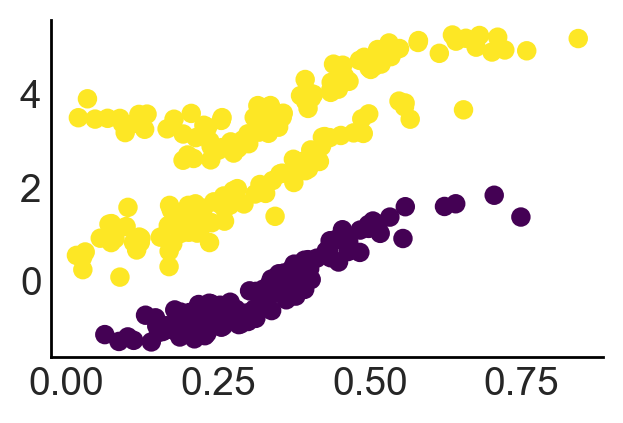

In [37]:
X_h_true = jnp.transpose(jnp.array([[1]*n, h_1, x, h_zeigen]))
X_h_obs = jnp.transpose(jnp.array([[1]*n, h_1, x, h_zeigen_obs]))

ell_h = jnp.array(c*jnp.max(jnp.abs(h_zeigen))).reshape(1,1)
ell_h_obs = jnp.array(c*jnp.max(jnp.abs(h_zeigen_obs))).reshape(1,1)

# Y_test,epsi_test = gen_y(X_h_true[:,0:3], h_zeigen, alpha, lin=False)
# Y_test,epsi_test = gen_y(X_h_true[:,0:3], h_zeigen, alpha, lin=True)
Y_test, epsi_test = gen_y(X_h_true[:,0:3], h_zeigen, alpha, lin=False)
# Y_test2,_ = gen_y(X_test_true2[:,0:3], true_h_x_eigen2,alpha,lin=False)

mu_test = Y_test - epsi_test
true_estimand = np.mean(mu_test)
# true_ce = Y_test - Y_test2

plt.figure(figsize=(3,2))
plt.scatter(h_zeigen,mu_test, c=h_1)
# plt.scatter(mean_y,mu_test, c =h_x)

In [38]:
def compute_error_stats(esti_post_draws, true_estimand, method="TEST", iter=None):
    mean = np.round(np.mean(esti_post_draws),3) 
    medi = np.round(np.median(esti_post_draws),3) 
    std = np.round(np.std(esti_post_draws),3)
    RMSE = np.round(np.sqrt(np.mean(np.power(esti_post_draws - true_estimand, 2))),3)
    q025 = np.round(np.quantile(esti_post_draws, 0.025),3)
    q975 = np.round(np.quantile(esti_post_draws, 0.975),3)
    cover = q025 <= true_estimand <= q975
    return {"iter" : iter, "method" : method,
            "mean" : mean, "median" : medi, "true" : np.round(true_estimand,3), 
            "bias" : np.round(mean - true_estimand,3), "std" : std, "RMSE" : RMSE,
            "q025" : q025, "q975" : q975, "covering" : cover}

(16000, 300)
(16000,)
{'iter': None, 'method': 'TEST', 'mean': Array(1.595, dtype=float32), 'median': 1.595, 'true': 1.598, 'bias': Array(-0.003, dtype=float32), 'std': Array(0.054, dtype=float32), 'RMSE': 0.054, 'q025': 1.489, 'q975': 1.702, 'covering': True}


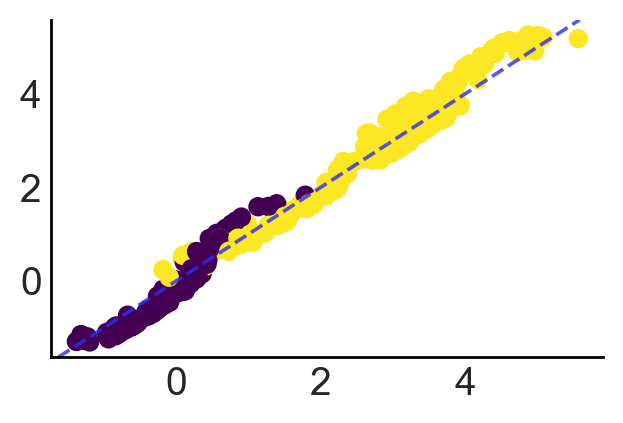

In [39]:
# post_pred_true_net = true_net_lin_predictive(rng_key, X=X_h_true)
post_pred_true_net = outcome_jit_pred(samples_net_true, X_h_true)
# post_pred_true_net = outcome_jit_pred(samples_net_true, X_h_true)
print(post_pred_true_net["Y"].shape)
# post_pred_true_net2 = true_net_lin_predictive(rng_key, X=X_test_true2)
lin_pred_true_net = np.mean(post_pred_true_net["Y"],axis=0)
lin_pred_true_net_it = np.mean(post_pred_true_net["Y"],axis=1)
print(lin_pred_true_net_it.shape)

lin_pred_true_stats = compute_error_stats(lin_pred_true_net_it, true_estimand)
print(lin_pred_true_stats)

plt.figure(figsize=(3,2))
plt.scatter(x=lin_pred_true_net,y=mu_test, c=h_1)
plt.axline((0,0),slope=1,ls="--",alpha=0.8,lw=1.3)

(300,) (16000,)
{'iter': None, 'method': 'TEST', 'mean': Array(1.96, dtype=float32), 'median': 1.961, 'true': 1.598, 'bias': Array(0.36200002, dtype=float32), 'std': Array(0.105, dtype=float32), 'RMSE': 0.377, 'q025': 1.753, 'q975': 2.167, 'covering': False}


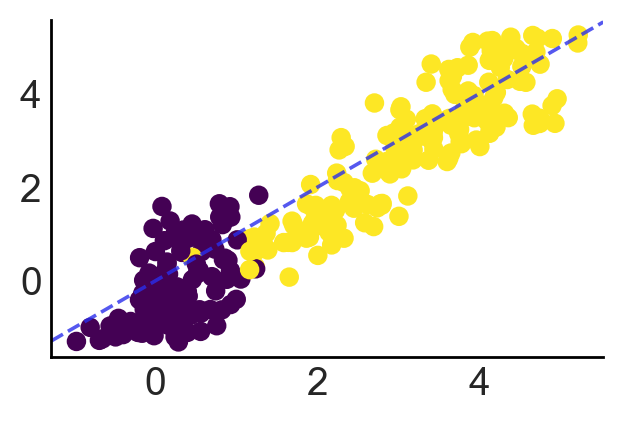

In [40]:
post_pred_obs = outcome_jit_pred(samples_net_obs, X_h_obs)
# post_pred_obs = outcome_jit_pred(samples_net_obs, X_h_obs)
lin_pred_obs = np.mean(post_pred_obs["Y"],axis=0)
lin_pred_obs_it = np.mean(post_pred_obs["Y"],axis=1)
print(lin_pred_obs.shape, lin_pred_obs_it.shape)

lin_pred_obs_stats = compute_error_stats(np.mean(post_pred_obs["Y"],axis=1), true_estimand)
print(lin_pred_obs_stats)

plt.figure(figsize=(3,2))
plt.scatter(x=lin_pred_obs,y=mu_test, c=h_1)
plt.axline((0,0),slope=1,ls="--",alpha=0.8,lw=1.3)

(16000, 300)
{'iter': None, 'method': 'TEST', 'mean': Array(1.5730001, dtype=float32), 'median': 1.573, 'true': 1.598, 'bias': Array(-0.025, dtype=float32), 'std': Array(0.049, dtype=float32), 'RMSE': 0.055, 'q025': 1.477, 'q975': 1.67, 'covering': True}


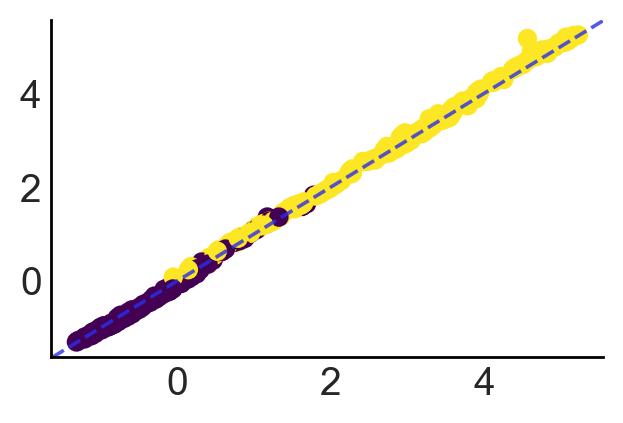

In [41]:
# HSGP_posterior_predictive = HSGP_true_predictive(rng_key, Xgp=X_h_true[:,3:], Xlin = X_h_true[:,0:3],ell=ell, m=M)
HSGP_posterior_predictive = HSGP_jit_pred(samples_GP_net_true, Xgp=X_h_true[:,3:], Xlin = X_h_true[:,0:3],ell=ell)
# HSGP_posterior_predictive = HSGP_true_predictive(rng_key, Xgp=X_h_true[:,3:], Xlin = X_h_true[:,0:3],ell=ell, m=m)
# HSGP_posterior_predictive = HSGP_jit_pred(samples_GP_net_true,Xgp=X_h_true[:,3:], Xlin = X_h_true[:,0:3],ell=ell, m=m)
print(HSGP_posterior_predictive["Y"].shape)
post_mu = np.mean(HSGP_posterior_predictive["Y"],axis=0)
post_mu_iter = np.mean(HSGP_posterior_predictive["Y"],axis=1)

hsgp_pred_true_stats = compute_error_stats(post_mu_iter, true_estimand)
print(hsgp_pred_true_stats)

plt.figure(figsize=(3,2))
plt.scatter(x=post_mu,y=mu_test, c=h_1)
# plt.scatter(x=post_mu2,y=mu_test2, c=true_h_x_eigen2)
plt.axline((0,0),slope=1,ls="--",alpha=0.8,lw=1.3)

(16000, 300)
{'iter': None, 'method': 'TEST', 'mean': Array(1.9160001, dtype=float32), 'median': 1.922, 'true': 1.598, 'bias': Array(0.31800002, dtype=float32), 'std': Array(0.15900001, dtype=float32), 'RMSE': 0.356, 'q025': 1.584, 'q975': 2.211, 'covering': True}


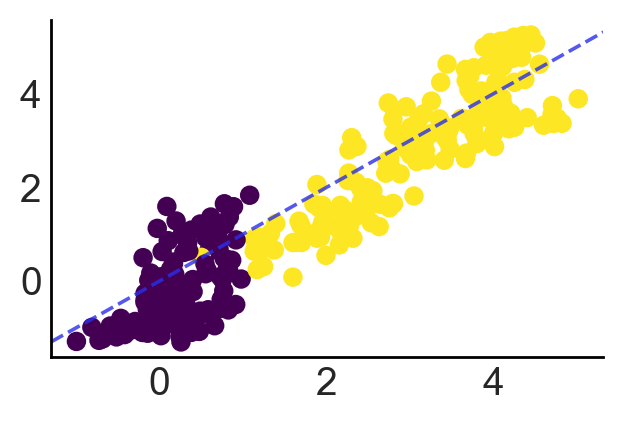

In [42]:
HSGP_posterior_predictive_obs = HSGP_jit_pred(samples_GP_net_obs, Xgp=X_h_obs[:,3:], Xlin = X_h_obs[:,0:3],ell=ell_obs)
# HSGP_posterior_predictive_obs = HSGP_obs_predictive(rng_key, Xgp=X_h_obs[:,3:], Xlin = X_h_obs[:,0:3], ell=ell_obs, m=M)
# HSGP_posterior_predictive = HSGP_jit_pred(samples_GP_net_true,Xgp=X_h_true[:,3:], Xlin = X_h_true[:,0:3],ell=ell, m=m)
print(HSGP_posterior_predictive_obs["Y"].shape)
obs_post_mu = np.mean(HSGP_posterior_predictive_obs["Y"],axis=0)
obs_post_mu_iter = np.mean(HSGP_posterior_predictive_obs["Y"],axis=1)

hsgp_pred_obs_stats = compute_error_stats(np.mean(HSGP_posterior_predictive_obs["Y"],axis=1), true_estimand)
print(hsgp_pred_obs_stats)

plt.figure(figsize=(3,2))
plt.scatter(x=obs_post_mu,y=mu_test, c=h_1)
# plt.scatter(x=post_mu2,y=mu_test2, c=true_h_x_eigen2)
plt.axline((0,0),slope=1,ls="--",alpha=0.8,lw=1.3)


In [43]:
post_pred_mean = {"beta" : jnp.expand_dims(jnp.mean(samples_network["beta"],axis=0),-2),
                  "gamma0" : jnp.expand_dims(jnp.mean(samples_network["gamma0"]),-1),
                  "gamma1" : jnp.expand_dims(jnp.mean(samples_network["gamma1"]),-1)}
print(post_pred_mean)

{'beta': Array([[-1.9016219, -0.580249 ]], dtype=float32), 'gamma0': Array([0.05234896], dtype=float32), 'gamma1': Array([0.27144083], dtype=float32)}


In [44]:
print(samples_network["beta"].shape)
print(samples_network["gamma0"].shape)
post_pred_mean = {"beta" : jnp.expand_dims(jnp.mean(samples_network["beta"],axis=0),-2),
                  "gamma0" : jnp.expand_dims(jnp.mean(samples_network["gamma0"]),-1),
                  "gamma1" : jnp.expand_dims(jnp.mean(samples_network["gamma1"]),-1)}
# print(jnp.array(post_pred_mean))
# The following is how to sample multiple different A* with the mean posterior of A* and A|A* parameters
# a_star_pred1 = a_star_pred(random.PRNGKey(0), X=x_diff,TriU=triu_obs,n=n)
# a_star_pred1 = Astar_pred(random.PRNGKey(0),post_samples=samples_network, Xd=x_diff,triu=triu_obs)
a_star_pred1 = Astar_pred(random.PRNGKey(0),post_samples=post_pred_mean, Xd=x_diff,triu=triu_obs)
a_star_pred2 = Astar_pred(random.PRNGKey(3),post_samples=post_pred_mean, Xd=x_diff,triu=triu_obs)
# a_star_pred2 = Astar_pred(random.PRNGKey(),post_samples=jnp.array(post_pred_mean), Xd=x_diff,triu=triu_obs, mean_post=True)
# a_star_pred2 = a_star_pred(random.PRNGKey(1), X=x_diff,TriU=triu_obs,n=n)
# a_star_pred2 = a_star_pred(random.PRNGKey(1), X=x_diff,TriU=triu_obs,n=n)
# print(a_star_pred)
# print(a_star_pred1["triu_star"])
print(a_star_pred1["triu_star"].shape)
print(a_star_pred1["triu_star"][0].shape)
print(a_star_pred2["triu_star"].shape)
print(jnp.array_equal(a_star_pred1["triu_star"],a_star_pred2["triu_star"]))

twoAst = pd.DataFrame({'first' : a_star_pred1["triu_star"][1], 'sec' : a_star_pred2["triu_star"][1]})
# print(twoAst)
pd.crosstab(index=twoAst['first'], columns=twoAst['sec'])

(16000, 2)
(16000,)
(1, 44850)
(44850,)
(1, 44850)
False


sec,0,1
first,,
0,41747,1224
1,1203,676


In [45]:
post_predictive = Predictive(network_model, samples_network, infer_discrete=True)
post_predictive = post_predictive(rng_key, X=x_diff,TriU=triu_obs)
# samples_network["triu_star"] = post_predictive["triu_star"]
# print(post_predictive["triu_star"])
print(post_predictive["triu_star"].shape)
print(post_predictive["triu_star"][0,].shape)

(16000, 44850)
(44850,)


In [ ]:

st = time.time()
for i in range(100):
    # A2 = Triu_to_mat(a_star_pred1["triu_star"][i])
     Triu_to_mat(Astar_pred(random.PRNGKey(i),post_samples=post_pred_mean, Xd=x_diff,triu=triu_obs)["triu_star"][0])
    #  Triu_to_mat(post_predictive["triu_star"][i,])
print("jax.jit takes: ", time.time() - st)

# np.array(Triu_to_mat(a_star_pred1["triu_star"][0])).shape

# print(np.array_equal(A1,A2))


In [46]:
NN = n

n_warmup = 250
n_samples = 50
n_chains = 2
M = m

@jit
def linear_model_sampless(key, Y, df):
    kernel_outcome = NUTS(outcome_model)
    lin_mcmc = MCMC(kernel_outcome, num_warmup=n_warmup, num_samples=n_samples,num_chains=n_chains, progress_bar=False, chain_method="vectorized")
    # mcmc.run(key, Y=Y, Z=Z, X=X, A=A, n=NN)
    lin_mcmc.run(key, X=df, Y=Y)
    return lin_mcmc.get_samples()

@jit    
def HSGP_model_sampless(key, Y, Xgp, Xlin, ell):
    kernel_hsgp = NUTS(HSGP_model)
    hsgp_mcmc = MCMC(kernel_hsgp, num_warmup=n_warmup, num_samples=n_samples,num_chains=n_chains, progress_bar=False, chain_method="vectorized")
    # mcmc.run(key, Y=Y, Z=Z, X=X, A=A, n=NN)
    hsgp_mcmc.run(key, Xgp=Xgp, Xlin=Xlin, ell=ell ,m=M, Y=Y)
    # samples = hsgp_mcmc.get_samples()
    # hsgp_pred = Predictive(HSGP_model, hsgp_mcmc.get_samples())
    # return hsgp_pred
    return hsgp_mcmc.get_samples()

@jit
def compute_net_stats(Astar, Z, return_ell = True):
    cur_eigen_cen = eigen_centrality(Astar)
    cur_Zeigen = zeigen_value(Z, cur_eigen_cen, Astar)
    cur_ell = c*jnp.max(jnp.abs(cur_Zeigen))
    # cur_ell = jnp.array(cur_ell)[..., None]
    cur_ell = jnp.array(cur_ell).reshape(1,1)
    if return_ell:
        return cur_Zeigen, cur_ell
    else:
        return cur_Zeigen
    
@jit    
def get_samples_new_Astar(key, Y, Z, X, curr_Astar):
        cur_Zeigen, ell = compute_net_stats(curr_Astar, Z)
        # get df
        # cur_df = np.transpose(np.array([[1]*NN, Z, X, cur_Zeigen]))
        cur_df = jnp.transpose(jnp.array([[1]*NN, Z, X, cur_Zeigen]))
        # Run MCMC
        cur_lin_samples = linear_model_sampless(key, Y, cur_df)
        cur_hsgp_samples = HSGP_model_sampless(key, Y=Y, Xgp=cur_df[:,3:],
                                                    Xlin=cur_df[:,0:3], ell=ell)
        # cur_hsgp_predictive = Predictive(HSGP_model, HSGP_model_samples(key, Y=Y, Xgp=cur_df[:,3:],
        #                                     Xlin=cur_df[:,0:3], ell=ell))
        # cur_hsgp_predictive = HSGP_model_samples(key, Y=Y, Xgp=cur_df[:,3:],
        #                                     Xlin=cur_df[:,0:3], ell=ell)
                                                 # m=jnp.array(m).reshape(1,1))
        return cur_lin_samples, cur_hsgp_samples, cur_df, ell 
        # return cur_lin_samples, cur_hsgp_predictive, cur_df, ell 

@jit        
def get_predicted_values(key, curr_df, lin_samples, hsgp_samples, ell):
        # get predicted values 
        # each has shape (#lin_samples, n)
        cur_lin_pred = outcome_jit_pred(lin_samples, curr_df, key)
        cur_hsgp_pred = HSGP_jit_pred(hsgp_samples,Xgp=curr_df[:,3:], Xlin = curr_df[:,0:3],ell=ell)
        # cur_hsgp_pred = hsgp_pred(key, Xgp=curr_df[:,3:], Xlin=curr_df[:,0:3],
        #                                     ell=ell, m=M)
                                            # m=m)
        # get estimands for each sample (sample mean across units)
        lin_estimates = jnp.mean(cur_lin_pred["Y"],axis=1)
        hsgp_estimates = jnp.mean(cur_hsgp_pred["Y"],axis=1)
        return lin_estimates, hsgp_estimates
               
@jit
def multistage_mcmc(samp_net, Y, Z_obs, Z_new, X):
    # cur_key = random.PRNGKey(i)
    # sample network
    # curr_triu_star = Astar_pred(cur_key, post_samples=post_mean, Xd=x_diff,triu=triu_obs)
    # curr_Astar = Triu_to_mat(curr_triu_star["triu_star"][0])
    curr_Astar = Triu_to_mat(samp_net)
    # re-run MCMC with new network
    curr_lin_samples, curr_hsgp_samples, cur_df, cur_ell = get_samples_new_Astar(rng_key_, Y, Z_obs, X, curr_Astar)
    # curr_lin_samples, curr_hsgp_pred, cur_df, cur_ell = get_samples_new_Astar(cur_key, Y, Z_obs, X, curr_Astar, m)
    # get predicted estimands for new `Z' values
    if Z_new.ndim == 1:
        # new_df = np.copy(cur_df)
        # new_df[:,1] = Z_new
        new_df = cur_df.at[:,1].set(Z_new)
        lin_estimates, hsgp_estimates = get_predicted_values(rng_key_, new_df, curr_lin_samples, curr_hsgp_samples, cur_ell)
        # lin_estimates, hsgp_estimates = get_predicted_values(cur_key, new_df, curr_lin_samples, curr_hsgp_pred, cur_ell, m)
        return jnp.array([lin_estimates, hsgp_estimates])
    # if Z_new.ndim == 2:
    #     n_iter = Z_new.shape[0]
    #     lin_results = []
    #     hsgp_results = []
    #     for j in range(n_iter):
    #         new_df = np.copy(cur_df)
    #         new_df[:,1] = Z_new[j]
    #         lin_estimates, hsgp_estimates = get_predicted_values(rng_key_, new_df, curr_lin_samples, curr_hsgp_pred, cur_ell, M)
    #         lin_results.append([lin_estimates])
    #         hsgp_results.append([hsgp_estimates])
    #         return np.array(lin_results), np.array(hsgp_results)
     

@jit
def Astar_pred(i, post_samples, Xd, triu):
    # if mean_post:
    pred_func = Predictive(model=network_model, posterior_samples=post_samples, infer_discrete=True,num_samples=1)
    # else:
    #     pred_func = Predictive(model=network_model, posterior_samples=post_samples, infer_discrete=True)
    samp_net = pred_func(random.PRNGKey(i**2), X=Xd, TriU=triu)["triu_star"]
    return jnp.squeeze(samp_net, axis=0)     
     
     
vectorized_astar_pred = jax.vmap(Astar_pred, in_axes=(0, None, None, None))
vectorized_multistage = jax.vmap(multistage_mcmc, in_axes=(0, None, None, None, None))
parallel_multistage = jax.pmap(multistage_mcmc, in_axes=(0, None, None, None, None))



#      
# start = time.time()
# # twostage_post_samp_jit = pd.DataFrame()
# twostage_linear = []
# twostage_hsgp = []
# # for i in tqdm(range(50)):
# for i in tqdm(range(3)):
#     cur_lin, cur_hsgp = twostage_jj(Astar_pred, post_pred_mean, Y, Z, h_1, x, x_diff, triu_obs, i)
#     # cur_lin, cur_hsgp = twostage_jj(Astar_pred, post_pred_mean, Y, Z, h_1, x, x_diff, triu_obs, i, m)
#     twostage_linear.append(cur_lin)
#     twostage_hsgp.append(cur_hsgp)
#     # twostage_post_samp_jit = pd.concat([twostage_post_samp_jit,cur_res])    
# # print(twostage_post_samp_jit)
# twostage_linear = np.array(twostage_linear)
# twostage_hsgp = np.array(twostage_hsgp)
# print("lin shape:", twostage_linear.shape, "\n",
#       "hsgp shape:", twostage_hsgp.shape)
# print("with JIT (non parallel) takes: ", time.time() - start)


In [47]:
    
start = time.time()
K = 100
irange = jnp.arange(K)
many_samp_triu = vectorized_astar_pred(irange, post_pred_mean, jnp.array(x_diff), jnp.array(triu_obs))
print(time.time() -start)


6.060600996017456


In [48]:
many_samp_triu.shape

(100, 44850)

In [ ]:
# start = time.time()
# test_twos = vectorized_multistage(many_samp_triu, Y, jnp.array(Z), jnp.array(h_1), jnp.array(x))
# print(test_twos.shape)
# print(time.time() - start)

In [49]:
start = time.time()
test_twos_pm = []
for i in range(0,K,4):
    i_results = parallel_multistage(many_samp_triu[i:(i+4),], Y, jnp.array(Z), jnp.array(h_1), jnp.array(x))
    test_twos_pm.append(i_results)
    # test_twos_pm = test_twos_pm.at[i:(i+3),:,:].set(i_samp)
test_twos_pm = jnp.concatenate(test_twos_pm, axis=0)
print(test_twos_pm.shape)
print(time.time() - start)

(100, 2, 100)
78.87248158454895


In [50]:
samp = test_twos_pm.shape[2]
twostage_lin = test_twos_pm[:, 0, :]
twostage_hsgp = test_twos_pm[:, 1, :]
twostage_linear_long = twostage_lin.reshape(K*samp)
twostage_hsgp_long = twostage_hsgp.reshape(K*samp)
print(compute_error_stats(twostage_linear_long, true_estimand, "linear two stage"), "\n",
      compute_error_stats(twostage_hsgp_long, true_estimand, "hsgp two stage"))

{'iter': None, 'method': 'linear two stage', 'mean': Array(1.263, dtype=float32), 'median': 1.266, 'true': 1.598, 'bias': Array(-0.335, dtype=float32), 'std': Array(0.06900001, dtype=float32), 'RMSE': 0.342, 'q025': 1.102, 'q975': 1.39, 'covering': False} 
 {'iter': None, 'method': 'hsgp two stage', 'mean': Array(1.268, dtype=float32), 'median': 1.266, 'true': 1.598, 'bias': Array(-0.33, dtype=float32), 'std': Array(0.067, dtype=float32), 'RMSE': 0.337, 'q025': 1.139, 'q975': 1.404, 'covering': False}


In [ ]:

# import importlib
# import sys
# modules_to_reload = list(sys.modules.keys())
# 
# for module_name in modules_to_reload:
#     if module_name.startswith("hsgp"):  # Specify the module prefix or condition
#         importlib.reload(sys.modules[module_name])
#         print(f"Reloaded module: {module_name}")
        

In [51]:
# threestage
i_range = np.random.choice(a = range(post_predictive["triu_star"].shape[0]), size = K, replace = False)
multi_post_triu = post_predictive["triu_star"][i_range,]

start = time.time()
test_threes_pm = []
for i in range(0,K,4):
    i_results = parallel_multistage(multi_post_triu[i:(i+4),], Y, jnp.array(Z), jnp.array(h_1), jnp.array(x))
    test_threes_pm.append(i_results)
    # test_twos_pm = test_twos_pm.at[i:(i+3),:,:].set(i_samp)
test_threes_pm = jnp.concatenate(test_threes_pm, axis=0)
print(test_threes_pm.shape)
print(time.time() - start)

(100, 2, 100)
46.17234992980957


In [52]:
samp = test_threes_pm.shape[2]
threestage_lin = test_threes_pm[:, 0, :]
threestage_hsgp = test_threes_pm[:, 1, :]
threestage_linear_long = threestage_lin.reshape(K*samp)
threestage_hsgp_long = threestage_hsgp.reshape(K*samp)
print(compute_error_stats(threestage_linear_long, true_estimand, "linear 3-stage"), "\n",
      compute_error_stats(threestage_hsgp_long, true_estimand, "hsgp 3-stage"))

{'iter': None, 'method': 'linear 3-stage', 'mean': Array(1.2650001, dtype=float32), 'median': 1.268, 'true': 1.598, 'bias': Array(-0.333, dtype=float32), 'std': Array(0.07, dtype=float32), 'RMSE': 0.34, 'q025': 1.104, 'q975': 1.392, 'covering': False} 
 {'iter': None, 'method': 'hsgp 3-stage', 'mean': Array(1.269, dtype=float32), 'median': 1.268, 'true': 1.598, 'bias': Array(-0.32900003, dtype=float32), 'std': Array(0.068, dtype=float32), 'RMSE': 0.336, 'q025': 1.139, 'q975': 1.406, 'covering': False}


In [ ]:

def threestage_jj(triu_post_samp, Y, Z_obs, Z_new, X, i):
    cur_key = random.PRNGKey(i)
    # triu to adj mat
    curr_Astar = Triu_to_mat(triu_post_samp)
    # re-run MCMC with new network
    curr_lin_samples, curr_hsgp_pred, cur_df, cur_ell = get_samples_new_Astar(cur_key, Y, Z_obs, X, curr_Astar)
    # curr_lin_samples, curr_hsgp_pred, cur_df, cur_ell = get_samples_new_Astar(cur_key, Y, Z_obs, X, curr_Astar, m)
    # get predicted estimands for new `Z' values
    if Z_new.ndim == 1:
        # new_df = np.copy(cur_df)
        # new_df[:,1] = Z_new
        new_df = cur_df.at[:,1].set(Z_new)
        lin_estimates, hsgp_estimates = get_predicted_values(cur_key, new_df, curr_lin_samples, curr_hsgp_pred, cur_ell)
        # lin_estimates, hsgp_estimates = get_predicted_values(cur_key, new_df, curr_lin_samples, curr_hsgp_pred, cur_ell, m)
        return lin_estimates, hsgp_estimates
    if Z_new.ndim == 2:
        n_iter = Z_new.shape[0]
        lin_results = []
        hsgp_results = []
        for j in range(n_iter):
            new_df = np.copy(cur_df)
            new_df[:,1] = Z_new[j]
            lin_estimates, hsgp_estimates = get_predicted_values(cur_key, new_df, curr_lin_samples, curr_hsgp_pred, cur_ell, m)
            lin_results.append(lin_estimates)
            hsgp_results.append(hsgp_estimates)
            return np.array(lin_results), np.array(hsgp_results)
     
     
start = time.time()
K = 100
i_range = np.random.choice(a = range(post_predictive["triu_star"].shape[0]), size = K, replace = False)
# twostage_post_samp_jit = pd.DataFrame()
threestage_linear = []
threestage_hsgp = []
# for i in tqdm(range(50)):
for i in tqdm(i_range):
    cur_lin, cur_hsgp = threestage_jj(post_predictive["triu_star"][i,], Y, Z, h_1, x, i)
    # cur_lin, cur_hsgp = twostage_jj(Astar_pred, post_pred_mean, Y, Z, h_1, x, x_diff, triu_obs, i, m)
    threestage_linear.append(cur_lin)
    threestage_hsgp.append(cur_hsgp)
    # twostage_post_samp_jit = pd.concat([twostage_post_samp_jit,cur_res])    
# print(twostage_post_samp_jit)
threestage_linear = np.array(threestage_linear)
threestage_hsgp = np.array(threestage_hsgp)
print("lin shape:", threestage_linear.shape, "\n",
      "hsgp shape:", threestage_hsgp.shape)
print("with JIT (non parallel) takes: ", time.time() - start)


In [ ]:
m, samp = threestage_linear.shape
threestage_linear_long = threestage_linear.reshape(m*samp)
threestage_hsgp_long = threestage_hsgp.reshape(m*samp)
print(compute_error_stats(threestage_linear_long, true_estimand, "linear three stage"), "\n",
      compute_error_stats(threestage_hsgp_long, true_estimand, "hsgp three stage"))

In [ ]:
mean_alpha2 = np.mean(threestage_post_samp_jit["alpha_2"])

def between_var(x, mean_all):
    n_rep = len(x)
    return (1/(n_rep - 1))*np.sum(np.square(x-mean_alpha2))

alpha2_agg_by_iter = threestage_post_samp_jit[["iter","alpha_2"]].groupby("iter").agg(["mean","var"])
alpha2_agg_by_iter.columns = ["mean","var"]
alpha2_VB = between_var(alpha2_agg_by_iter["mean"], mean_alpha2)
alpha2_VW = np.mean(alpha2_agg_by_iter["var"])

alpha2_MI_var = alpha2_VB*(1 + 1/K) + alpha2_VW
print("VB: ", alpha2_VB, "VW: ", alpha2_VW, " Total var: ", alpha2_MI_var,
      " Naive var: ", np.var(threestage_post_samp_jit["alpha_2"]))



In [53]:

# `cut posterior` : for each A* and A|A* param, sample one A*, and compute network statistics distribution (e.g., degrees and exposures)
# The uncertainty in A* and A|A* *doesn't* propagate into the outcome model which depends on the network statistics
# Use the mean network stat in the outcome model (i.e., only one outcome model run!).

@jit
def network_posterior_stats(triu_sample, Z_old, Z_new):
    curr_Astar = Triu_to_mat(triu_sample)    
    # curr_degree = jnp.sum(curr_Astar,1)
    cur_eig_cen = eigen_centrality(curr_Astar)
    Zeigen_old = zeigen_value(Z_old, cur_eig_cen, curr_Astar)
    Zeigen_new = zeigen_value(Z_new, cur_eig_cen, curr_Astar)
    return jnp.array([Zeigen_old, Zeigen_new])
    
parallel_network_post_stats = jax.pmap(network_posterior_stats, in_axes=(0, None, None))
vectorized_network_post_stats = jax.vmap(network_posterior_stats, in_axes=(0, None, None))


In [ ]:
# start = time.time()
# mean_zeigen_vec = vectorized_network_post_stats(post_predictive["triu_star"], Z, h_1)
# print(mean_zeigen_vec.shape)
# print(time.time() - start)

In [54]:
start = time.time()
mean_zeigen_par = []
for i in range(0,post_predictive["triu_star"].shape[0],4):
    i_results = parallel_network_post_stats(post_predictive["triu_star"][i:(i+4),], Z, h_1)
    mean_zeigen_par.append(i_results)
    # test_twos_pm = test_twos_pm.at[i:(i+3),:,:].set(i_samp)
mean_zeigen_par = jnp.concatenate(mean_zeigen_par, axis=0)
print(mean_zeigen_par.shape)
print(time.time() - start)

(16000, 2, 300)
107.86646580696106


In [55]:
post_zeigen_old = mean_zeigen_par[:,0,:]
post_zeigen_new = mean_zeigen_par[:,1,:]

In [56]:
mean_zeigen_obs = jnp.mean(post_zeigen_old, axis=0)
mean_zeigen_new = jnp.mean(post_zeigen_new, axis=0)

[[0.99999994 0.7133006 ]
 [0.7133006  1.        ]]


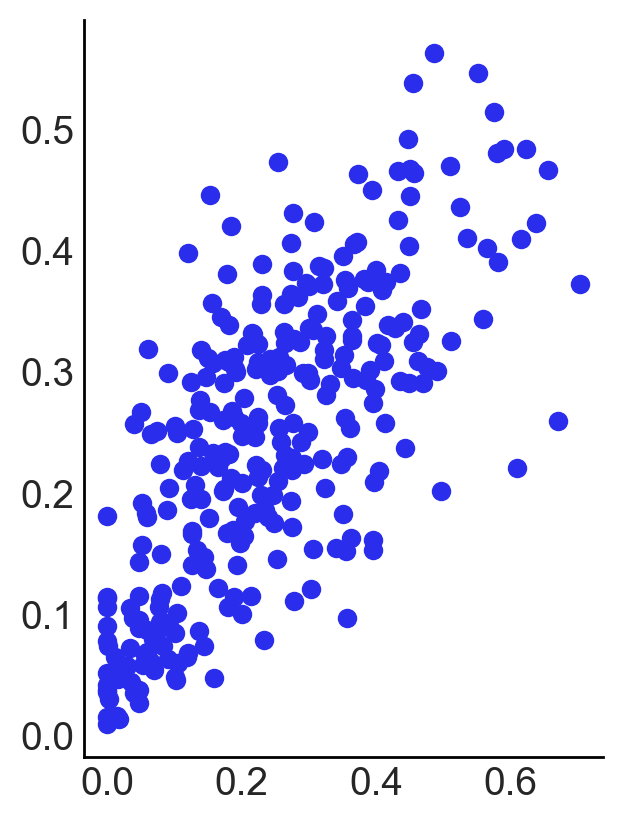

In [57]:
print(jnp.corrcoef(Zeigen, mean_zeigen_obs))
plt.figure(figsize=(3,4))
plt.scatter(Zeigen, mean_zeigen_obs)

[[1.         0.73841655]
 [0.73841655 1.        ]]


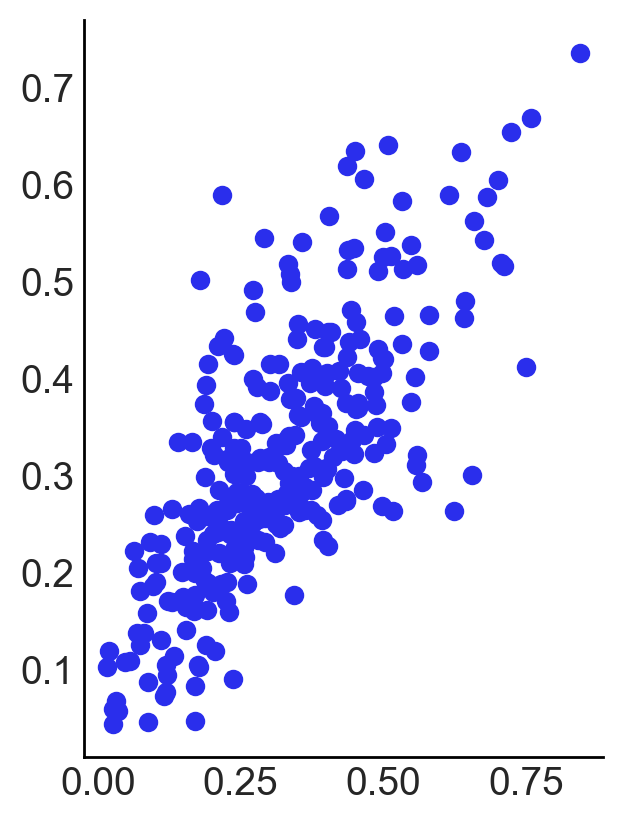

In [58]:
print(jnp.corrcoef(h_zeigen, mean_zeigen_new))
plt.figure(figsize=(3,4))
plt.scatter(h_zeigen, mean_zeigen_new)

In [ ]:

true_deg = np.sum(mat,1)
obs_deg = np.sum(obs_mat,1)

beige_color = '#FFFDFA'
pastel_purple_dark = (0.4, 0.2, 0.6)
# sns.set_theme(style="ticks", rc={'figure.facecolor': beige_color, 'axes.facecolor' : beige_color})
# sns.set_context("poster")


fig, axes = plt.subplots(nrows=1,ncols=2, sharex=True, sharey=True)
ax1, ax2 = axes.flatten()
# fig.patch.set_facecolor(beige_color)
# for ax in axes:
    # ax.set_facecolor(beige_color) 

# ax1.plot(a_star_pred_deg, a_star_true_deg,"o")
ax1.scatter(x=obs_deg,y=true_deg, marker = 'o',alpha=0.8,color=pastel_purple_dark,edgecolors="none")
ax1.axline((0,0),slope=1,c="black",ls="--",alpha=0.8,lw=1.3)
# plt.gca().set_facecolor(beige_color)
# ax2.plot(a_obs_deg, a_star_true_deg,"o")
ax2.scatter(x=mean_deg, y=true_deg, marker = 'o',alpha=0.8,color=pastel_purple_dark,edgecolors="none")
ax2.axline((0,0),slope=1,c="black",ls="--",alpha=0.8,lw=1.3)
# plt.gca().set_facecolor(beige_color)
ax2.set_xlabel("Posterior mean")
ax1.set_xlabel("Observed")
ax1.set_ylabel("True")
ax2.set_ylabel("True")

fig.suptitle('Degree distribution', fontsize=16)

fig = plt.gcf()
fig.set_size_inches(8, 4)
fig.savefig('deg_dist.png', dpi=300)

In [59]:
# one_stage_df = np.transpose(np.array([[1]*n, Z, x, mean_Zeigen]))
one_stage_df_obs = jnp.array(np.transpose(np.array([[1]*n, Z, x, mean_zeigen_obs])))
one_stage_df_new = jnp.array(np.transpose(np.array([[1]*n, h_1, x, mean_zeigen_new])))
one_stage_ell = jnp.array(c*jnp.max(jnp.abs(mean_zeigen_obs))).reshape(1,1)
one_stage_elln = jnp.array(c*jnp.max(jnp.abs(mean_zeigen_new))).reshape(1,1)

In [60]:
print(one_stage_ell, one_stage_elln)

[[1.9713101]] [[2.573316]]


In [ ]:
rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)

start = time.time()
kernel_stat_outcome = NUTS(outcome_model)
mcmc_network_stat = MCMC(kernel_stat_outcome, num_warmup=2000, num_samples=4000,num_chains=4)
mcmc_network_stat.run(rng_key_,Y=Y,X=one_stage_df_obs)
# mcmc_network_obs.run(rng_key_,Y=Y,Z=Z,A=mat,n=n)
mcmc_network_stat.print_summary()
samples_network_stat = mcmc_network_stat.get_samples()
print(time.time() - start)
print([f"alpha_{i} = {al}" for i,al in enumerate(alpha)],"sig:", 1)


(16000, 300)
(16000,)
{'iter': None, 'method': 'TEST', 'mean': Array(1.521, dtype=float32), 'median': 1.521, 'true': 1.598, 'bias': Array(-0.07700001, dtype=float32), 'std': Array(0.07, dtype=float32), 'RMSE': 0.104, 'q025': 1.383, 'q975': 1.659, 'covering': True}


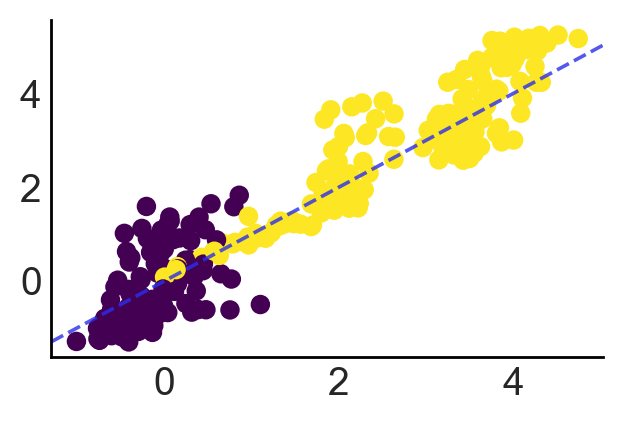

In [61]:

n_warmup = 2000
n_samples = 4000
n_chains = 4
M = m

@jit
def linear_model_samples(key, Y, df):
    kernel_outcome = NUTS(outcome_model)
    lin_mcmc = MCMC(kernel_outcome, num_warmup=n_warmup, num_samples=n_samples,num_chains=n_chains, progress_bar=False, chain_method="vectorized")
    # mcmc.run(key, Y=Y, Z=Z, X=X, A=A, n=NN)
    lin_mcmc.run(key, X=df, Y=Y)
    return lin_mcmc.get_samples()


samples_network_stat = linear_model_samples(rng_key_,Y=Y, df=one_stage_df_obs)
post_pred_true_net = outcome_jit_pred(samples_network_stat, one_stage_df_new)
# post_pred_true_net = outcome_jit_pred(samples_net_true, X_h_true)
print(post_pred_true_net["Y"].shape)
# post_pred_true_net2 = true_net_lin_predictive(rng_key, X=X_test_true2)
lin_pred_true_net = np.mean(post_pred_true_net["Y"],axis=0)
lin_pred_true_net_it = np.mean(post_pred_true_net["Y"],axis=1)
print(lin_pred_true_net_it.shape)

lin_pred_true_stats = compute_error_stats(lin_pred_true_net_it, true_estimand)
print(lin_pred_true_stats)

plt.figure(figsize=(3,2))
plt.scatter(x=lin_pred_true_net,y=mu_test, c=h_1)
plt.axline((0,0),slope=1,ls="--",alpha=0.8,lw=1.3)

(16000, 300)
{'iter': None, 'method': 'TEST', 'mean': Array(1.531, dtype=float32), 'median': 1.529, 'true': 1.598, 'bias': Array(-0.067, dtype=float32), 'std': Array(0.072, dtype=float32), 'RMSE': 0.099, 'q025': 1.389, 'q975': 1.672, 'covering': True}


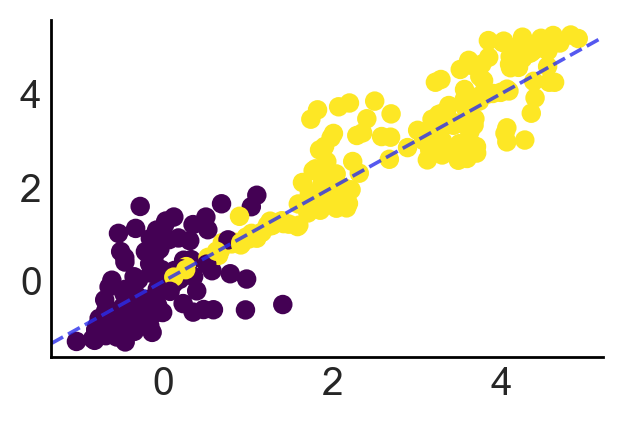

In [62]:
M = m
num_warmup=2000
num_samples=4000
num_chains=4

@jit    
def HSGP_model_samples(key, Y, Xgp, Xlin, ell):
    kernel_hsgp = NUTS(HSGP_model)
    hsgp_mcmc = MCMC(kernel_hsgp, num_warmup=num_warmup, num_samples=num_samples,num_chains=num_chains, progress_bar=False, chain_method="vectorized")
    # mcmc.run(key, Y=Y, Z=Z, X=X, A=A, n=NN)
    hsgp_mcmc.run(key, Xgp=Xgp, Xlin=Xlin, ell=ell ,m=M, Y=Y)
    # hsgp_mcmc.print_summary()
    # samples = hsgp_mcmc.get_samples()
    # hsgp_pred = Predictive(HSGP_model, hsgp_mcmc.get_samples())
    # return hsgp_pred
    return hsgp_mcmc.get_samples()

samples_GP_onestage = HSGP_model_samples(rng_key_,Y=Y, Xgp=one_stage_df_obs[:,3], Xlin=one_stage_df_obs[:,:3], ell=one_stage_ell)
# HSGP_onestage_predictive = Predictive(HSGP_model, samples_GP_onestage)
# HSGP_posterior_predictive = HSGP_true_predictive(rng_key, Xgp=X_h_true[:,3:], Xlin = X_h_true[:,0:3],ell=ell, m=m)
HSGP_onestage_post_pred = HSGP_jit_pred(samples_GP_onestage, Xgp=one_stage_df_new[:,3], Xlin=one_stage_df_new[:,:3], ell=one_stage_ell)
# HSGP_onestage_post_pred = HSGP_onestage_predictive(rng_key, Xgp=one_stage_df_new[:,3], Xlin=one_stage_df_new[:,:3], ell=one_stage_ell, m=M)


print(HSGP_onestage_post_pred["Y"].shape)
post_mu = np.mean(HSGP_onestage_post_pred["Y"],axis=0)
post_mu_iter = np.mean(HSGP_onestage_post_pred["Y"],axis=1)

hsgp_pred_true_stats = compute_error_stats(post_mu_iter, true_estimand)
print(hsgp_pred_true_stats)

plt.figure(figsize=(3,2))
plt.scatter(x=post_mu,y=mu_test, c=h_1)
# plt.scatter(x=post_mu2,y=mu_test2, c=true_h_x_eigen2)
plt.axline((0,0),slope=1,ls="--",alpha=0.8,lw=1.3)